In [623]:
#%% - Dependencies
# External Libraries
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os
import importlib.util
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from scipy import ndimage
import skimage.restoration
from sklearn.decomposition import PCA
from scipy.linalg import svd
import cv2
import cvxpy as cp
import bm3d
from medpy.filter.smoothing import anisotropic_diffusion
import torch
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error, normalized_mutual_information, normalized_root_mse, structural_similarity, simple_metrics, variation_of_information, adapted_rand_error, tests
from skimage import img_as_float
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte
from scipy import ndimage as nd


%matplotlib inline
from DC3D_V3.DC3D_V3_Denoiser_2 import deepclean3





# Function to create sparse signal from a fully dense signal
def create_sparse_signal(input_image_batch, signal_points=2, linear=False):

    """
    This function will take a batch of images and randomly select signal_points number of non-zero values to keep in each image, zeroing out all other values i.e if signal_points = 2 then only 2 non-zero values will be kept in each image and all other non zero values will be zeroed out, effectivly simulating a very sparse signal
    
    Args:
        input_image_batch (torch tensor): The input image batch to be degraded. Shape [B, C, H, W]
        signal_points (int): The number of non-zero values to keep in each image
        linear (bool): If set to true then the signal points are linearly spaced across the signal, otherwise they are randomly selected. Default = False
    """

    # Take as input a torch tensor in form [batch_size, 1, x_dim, y_dim]]
    # Create a copy of the input image batch
    image_batch = input_image_batch.clone()

    # Flatten the image tensor
    flat_batch = image_batch.view(image_batch.size(0), -1)

    # Count the number of non-zero values in each image
    nz_counts = torch.sum(flat_batch != 0, dim=1)

    # Find the indices of the images that have more non-zero values than signal_points
    sparse_indices = torch.where(nz_counts > signal_points)[0]

    # For each sparse image, randomly select signal_points non-zero values to keep
    for idx in sparse_indices:
        # Find the indices of the non-zero values in the flattened image
        nz_indices = torch.nonzero(flat_batch[idx]).squeeze()

        # Randomly select signal_points non-zero values to keep
        if linear:
            kept_indices = torch.linspace(0, nz_indices.numel() - 1, steps=signal_points).long()
        else:
            kept_indices = torch.randperm(nz_indices.numel())[:signal_points]

        # Zero out all non-selected values
        nonkept_indices = nz_indices[~torch.isin(nz_indices, nz_indices[kept_indices])]
        flat_batch[idx, nonkept_indices] = 0

    # Reshape the flat tensor back into the original shape
    output_image_batch = flat_batch.view_as(image_batch)

    return output_image_batch

















#%% - functions
# Import and prepare Autoencoder model


# New function to add n noise points to the 2d numpy array
def add_noise_points_nonorm(input_image, noise_points=100, time_dimension=100):
    image = input_image.clone()
    
    if noise_points > 0:
        #Find dimensions of input image 
        x_dim = image.shape[0]
        y_dim = image.shape[1]

        #Create a list of random x and y coordinates
        x_coords = np.random.randint(0, x_dim, noise_points)
        y_coords = np.random.randint(0, y_dim, noise_points)

        # Iterate through noise_points number of random pixels to noise
        for i in range(noise_points):

            # Add a random number between 0 and time_dimension to the pixel 
            image[x_coords[i], y_coords[i]] = np.random.uniform(0, time_dimension)
    return image

def image_loader(input_image_path, noise_points, signal_points, time_dimension=100):
    ### Load image from path 
    input_image = np.load(input_image_path)

    # make into tewnsor 
    input_image = torch.tensor(input_image)
    input_image = torch.unsqueeze(input_image, 0)
    input_image = torch.unsqueeze(input_image, 0)
    input_image = input_image.double()

    # reduce image to set signal points 
    input_image = create_sparse_signal(input_image, signal_points)

    # remove batch and channel dimensions
    input_image = input_image.squeeze(0)
    input_image = input_image.squeeze(0)

    # Add noise if noise_points is greater than 1
    noisy_image = add_noise_points_nonorm(input_image, noise_points, time_dimension)
    
    return input_image, noisy_image

def custom_normalisation(data, reconstruction_threshold, time_dimension=100):
    data = ((data / time_dimension) / (1/(1-reconstruction_threshold))) + reconstruction_threshold
    for row in data:   ###REPLACE USING NP.WHERE
        for i, ipt in enumerate(row):
            if ipt == reconstruction_threshold:
                row[i] = 0
    return data

def custom_renormalisation(data, reconstruction_threshold, time_dimension=100):
    data = np.where(data > reconstruction_threshold, ((data - reconstruction_threshold)*(1/(1-reconstruction_threshold)))*(time_dimension), 0)
    return data

def build_3d(data, time_dimension=100):
    # Apply the processing functions to the data
    shape = data.shape
    processed_data = np.zeros((shape[0], shape[1], time_dimension))

    i, j = np.nonzero(data)           # Compute the indices for the non-zero elements of data in the third dimension of array_3D
    k = data[i, j].astype(int)        # Convert the values to integers
    processed_data[i, j, k-1] = 1     # array_3D is now a 3D numpy array of size n by m by time_dimension_max, with the non-zero values from the original 2D array set to 1 in the appropriate location 
    return(processed_data)

def multi_3d_plotting(input_image, noised_image, rec_image, time_dimension=100, show_2d_projection=True):
    # Create a 3D plot with two subplots
    fig = plt.figure(figsize=(9, 9))
    titles = ['Input Image', 'Noised Image', 'Reconstructed Image']
    
    # Loop through both input_image and rec_image and create a 2d subplot for each
    for i, image in enumerate([input_image, noised_image, rec_image]):    
        ax = fig.add_subplot(2, 3, i+1)
        ax.imshow(image)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        # Set the title of the subplot
        ax.set_title(titles[i])
        
    # Loop through both input_image and rec_image and create a 3d subplot for each
    for i, image in enumerate([input_image, noised_image, rec_image]):
        ax = fig.add_subplot(2, 3, 3 + i+1, projection='3d')

        # Generate 3D image data
        image_3d = build_3d(image, time_dimension)
        
        # Assume image is your 3D array of size n by m by t_max
        n, m, t_max = image_3d.shape

        # Create a meshgrid of x, y, and z values for the 3D plot
        x, y, z = np.meshgrid(np.arange(m), np.arange(n), np.arange(t_max))

        # Flatten the x, y, and z values and image for plotting
        x = x.flatten()
        y = y.flatten()
        z = z.flatten()
        image_3d = image_3d.flatten()

        # Plot the 3D scatter plot with the non-zero values in the array set to 1
        ax.scatter(z[image_3d == 1], x[image_3d == 1], y[image_3d == 1], c=z[image_3d == 1], cmap='viridis', marker='o', s=10, alpha=0.5, depthshade=False, linewidth=0)
        ax.set_xlabel('t')
        ax.set_ylabel('x')
        ax.set_zlabel('y')
        ax.set_xlim(0, t_max)
        ax.set_ylim(0, 88)
        ax.set_zlim(0, 128)
        
        if show_2d_projection:
            # plot the projected 2D data on the xy-plane
            ax.scatter(np.zeros_like(z[image_3d == 1]), x[image_3d == 1], y[image_3d == 1], c='r', marker='o', s=10, alpha=0.3, depthshade=False, linewidth=0)

    # Show the plot
    plt.tight_layout()
    plt.show()





# Masking technique
def masking_recovery(input_image, recovered_image, print_result=True):
    raw_input_image = input_image.clone()
    net_recovered_image = recovered_image.copy()
    #Evaluate usefullness 
    # count the number of non-zero values
    masking_pixels = np.count_nonzero(net_recovered_image)
    image_shape = net_recovered_image.shape
    total_pixels = image_shape[0] * image_shape[1] * time_dimension
    # print the count
    if print_result:
        print(f"Total number of pixels in the timescan: {format(total_pixels, ',')}\nNumber of pixels returned by the masking: {format(masking_pixels, ',')}\nNumber of pixels removed from reconstruction by masking: {format(total_pixels - masking_pixels, ',')}")

    # use np.where and boolean indexing to update values in a
    mask_indexs = np.where(net_recovered_image != 0)
    net_recovered_image[mask_indexs] = raw_input_image[mask_indexs]
    result = net_recovered_image
    return result

In [624]:
#%% Helper functions for evaluating performance of the denoiser:

#Signal to Noise Ratio (SNR)
def SNR(clean_input, noised_target):
    """
    Calculates the Signal to Noise Ratio (SNR) of a given signal and noise.
    SNR is defined as the ratio of the magnitude of the signal and the magnitude of the noise.
    
    Args:
    clean_input (torch.Tensor): The original signal.
    noised_target (torch.Tensor): The signal with added noise.
    
    Returns:
    The calculated SNR value.    
    """
    signal_power = torch.mean(torch.pow(clean_input, 2))

    noise = clean_input - noised_target 
    noise_power = torch.mean(torch.pow(noise, 2))

    snr = 10 * torch.log10(signal_power / noise_power)
    return (float(snr.numpy()))

#Peak Signal-to-Noise Ratio (PSNR):
def PSNR(clean_input, noised_target, time_dimension):
    """
    Calculates the Peak Signal to Noise Ratio (PSNR) of a given image and its recovered version. PSNR is defined as the ratio of 
    the maximum possible power of a signal and the power of corrupting noise. The measure focuses on how well high-intensity 
    regions of the image come through the noise, and pays much less attention to low intensity regions.

    Args:
    clean_input (torch.Tensor): The original image.
    noised_target (torch.Tensor): The recovered image.
    
    Returns:
    The calculated PSNR value.
    """
    mse = torch.mean(torch.pow(clean_input - noised_target, 2))   #Finds the mean square error
    max_value = time_dimension
    psnr = 10 * torch.log10((max_value**2) / mse)
    return (float(psnr.numpy()))

#Mean Squared Error (MSE):
def MSE(clean_input, noised_target):
    """
    Mean Squared Error (MSE)

    Args:
    clean_input (torch.Tensor): The original image.
    noised_target (torch.Tensor): The recovered image.
    
    Returns:
    The calculated Mean Squared Error value.
    """
    mse = torch.mean(torch.pow(clean_input - noised_target, 2))
    return (float(mse.numpy()))

#Mean Absolute Error (MAE):
def MAE(clean_input, noised_target):
    """
    Mean Absolute Error (MAE)

    Args:
    clean_input (torch.Tensor): The original image.
    noised_target (torch.Tensor): The recovered image.
    
    Returns:
    The calculated Mean Absolute Error value.
    """
    return float((torch.mean(torch.abs(clean_input - noised_target))).numpy())

#Structural Similarity Index (SSIM):

def SSIM(clean_input, noised_target, time_dimension=100):
    """
    Structural Similarity Index Measure (SSIM), is a perceptual quality index that measures the structural similarity between 
    two images. SSIM takes into account the structural information of an image, such as luminance, contrast, and structure, 
    and compares the two images based on these factors. SSIM is based on a three-part similarity metric that considers the 
    structural information in the image, the dynamic range of the image, and the luminance information of the image. SSIM is 
    designed to provide a more perceptually relevant measure of image similarity than traditional metrics such as Mean Squared 
    Error or Peak Signal-to-Noise Ratio.

    Args:
    clean_input (torch.Tensor): The original image.
    noised_target (torch.Tensor): The recovered image.
    
    Returns:
    The calculated Structural Similarity Index Measure value.

    """
    clean_image = clean_input.detach().cpu().numpy()
    recovered_image = noised_target.detach().cpu().numpy()
    return structural_similarity(clean_image, recovered_image, data_range=time_dimension)

#Correlation Coefficent
def correlation_coeff(clean_input, noised_target):
    
    """
    Correlation coefficient is a scalar value that measures the linear relationship between two signals. The correlation 
    coefficient ranges from -1 to 1, where a value of 1 indicates a perfect positive linear relationship, a value of -1 indicates 
    a perfect negative linear relationship, and a value of 0 indicates no linear relationship between the two signals. Correlation 
    coefficient only measures the linear relationship between two signals, and does not take into account the structure of the signals.

    ρ = cov(x,y) / (stddev(x) * stddev(y))

    The function first computes the mean and standard deviation of each tensor, and then subtracts the mean from each element 
    to get the centered tensors x_center and y_center. The numerator is the sum of the element-wise product of x_center 
    and y_center, and the denominator is the product of the standard deviations of the two centered tensors multiplied by the 
    number of elements in the tensor. The function returns the value of the correlation coefficient ρ as the ratio of the numerator 
    and denominator.

    Args:
    clean_input (torch.Tensor): The original image.
    noised_target (torch.Tensor): The recovered image.
    
    Returns:
    The calculated correlation coefficient value.
    """
    clean_mean = clean_input.mean()
    noised_mean = noised_target.mean()
    clean_std = clean_input.std()
    noised_std = noised_target.std()
    clean_center = clean_input - clean_mean
    noised_center = noised_target - noised_mean
    numerator = (clean_center * noised_center).sum()
    denominator = clean_std * noised_std * clean_input.numel()
    return float((numerator / denominator).numpy())

#Mutual Information:
def NomalisedMutualInformation(clean_input, noised_target):
    clean_image = clean_input.detach().cpu().numpy()
    recovered_image = noised_target.detach().cpu().numpy()
    return normalized_mutual_information(clean_image, recovered_image)-1

def compare_images_pixels(clean_img, denoised_img, terminal_print=False):
    clean_img = clean_img.detach().cpu().numpy()
    denoised_img = denoised_img.detach().cpu().numpy()
    ###TRUE HITS STATS###
    if terminal_print:
        print("###TRUE HITS STATS###")
    
    ##X,Y##
    true_hits_indexs = np.nonzero(clean_img)     # Find the indexs of the non zero pixels in clean_img
    numof_true_hits = len(true_hits_indexs[0])   # Find the number of lit pixels in clean_img
    if terminal_print:
        print("numof_true_hits:", numof_true_hits)
    
    # Check the values in corresponding indexs in denoised_img, retunr the index's and number of them that are also non zero
    true_positive_xy_indexs = np.nonzero(denoised_img[true_hits_indexs]) 
    numof_true_positive_xy = len(true_positive_xy_indexs[0])                     # Calculate the number of pixels in clean_img that are also in denoised_img ###NUMBER OF SUCSESSFUL X,Y RECON PIXELS
    if terminal_print:
        print("numof_true_positive_xy:", numof_true_positive_xy)

    # Calculate the number of true hit pixels in clean_img that are not lit at all in denoised_img  ###NUMBER OF LOST TRUE PIXELS
    false_negative_xy = numof_true_hits - numof_true_positive_xy
    if terminal_print:
        print("false_negative_xy:", false_negative_xy)
    
    # Calculate the percentage of non zero pixels in clean_img that are also non zero in denoised_img   ###PERCENTAGE OF SUCSESSFUL X,Y RECON PIXELS
    percentage_of_true_positive_xy = (numof_true_positive_xy / numof_true_hits) * 100
    if terminal_print:
        print(f"percentage_of_true_positive_xy: {percentage_of_true_positive_xy}%")
    
    
    ##TOF##
    # Calculate the number of pixels in clean_img that are also in denoised_img and have the same TOF value  ###NUMBER OF SUCSESSFUL X,Y,TOF RECON PIXELS
    num_of_true_positive_tof = np.count_nonzero(np.isclose(clean_img[true_hits_indexs], denoised_img[true_hits_indexs], rtol=1e-6))
    if terminal_print:
        print("num_of_true_positive_tof:", num_of_true_positive_tof)
    
    # Calculate the percentage of pixels in clean_img that are also in denoised_img and have the same value   ###PERCENTAGE OF SUCSESSFUL X,Y,TOF RECON PIXELS
    percentage_of_true_positive_tof = (num_of_true_positive_tof / numof_true_hits) * 100
    if terminal_print:
        print(f"percentage_of_true_positive_tof: {percentage_of_true_positive_tof}%")    
    

    ###FALSE HIT STATS###
    if terminal_print:
        print("\n###FALSE HIT STATS###")
    clean_img_zero_pixels = np.where(clean_img == 0)   # find the index of the 0 valued pixels in clean image 
    number_of_zero_pixels = len(clean_img_zero_pixels[0])   # Find the number of pixels in clean image that are zero
    if terminal_print:
        print("number_of_true_zero_pixels:",number_of_zero_pixels)

    #check the values in corresponding indexs in denoised_img, return the number of them that are non zero
    denoised_img_false_lit_pixels = np.nonzero(denoised_img[clean_img_zero_pixels])
    numof_false_positives_xy = len(denoised_img_false_lit_pixels[0])
    if terminal_print:
        print("numof_false_positives_xy:",numof_false_positives_xy)

    # Calculate the percentage of pixels in clean_img that are zero and are also non zero in denoised_img   ###PERCENTAGE OF FALSE LIT PIXELS
    percentage_of_false_lit_pixels = (numof_false_positives_xy / number_of_zero_pixels) * 100
    if terminal_print:
        print(f"percentage_of_false_positives_xy: {percentage_of_false_lit_pixels}%")
    
    return percentage_of_true_positive_xy, percentage_of_true_positive_tof, numof_false_positives_xy


#Combine all performance metrics into simple test script
def quantify_performance(clean_input, noised_target, label, time_dimension):
    percentage_of_true_positive_xy, percentage_of_true_positive_tof, numof_false_positives_xy = compare_images_pixels(clean_input, noised_target)
    
    performance = {}
    performance['MSE'] = MSE(clean_input, noised_target)
    performance['MAE'] = MAE(clean_input, noised_target)
    performance['SNR'] = SNR(clean_input, noised_target)
    performance['PSNR'] = PSNR(clean_input, noised_target, time_dimension)
    performance['SSIM'] = SSIM(clean_input, noised_target, time_dimension)   #ADD TIME DIMENSION AS AN INPUT ARGH!!!!
    performance['NMI'] = NomalisedMutualInformation(clean_input, noised_target)    #BROKEN
    performance['CC'] = correlation_coeff(clean_input, noised_target)
    performance['Spatial Reconstruction'] = percentage_of_true_positive_xy
    performance['Temporal Reconstruction'] = percentage_of_true_positive_tof
    performance['Residual Noise'] = numof_false_positives_xy

    #Return dictionary with results for image
    return performance

In [625]:

#%% - Filters
# Gaussian Filter Denoiser
def gaussian_filter_denoise(image):


    image = ndimage.gaussian_filter(image, 2)


    return (image)

# Mediam Filter Denoiser
def median_filter_denoise(image):


    image = ndimage.median_filter(image, 2)


    return (image)

# Bilateral Filter Denoiser
def bilateral_filter_denoise(image, d=7, sigma_color=75, sigma_space=75):
    # Convert image from torch tensor to numpy array
    image = image.detach().numpy().squeeze()
    image = image.astype(np.float32)
    # Apply bilateral filter
    denoised_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)

    
    return denoised_image.astype(np.float64)

# Tilateral Filter Denoiser
def trilateral_filter_denoise(image, d=3, sigma_space=75):
    # Convert image from torch tensor to numpy array
    image = image.detach().numpy().squeeze()
    # Get the image shape
    rows, cols = image.shape
    # Create the domain and range weights
    domain_weights = np.zeros((rows, cols))
    range_weights = np.zeros((rows, cols))
    # Compute the mean filter
    mean_filter = cv2.boxFilter(image, -1, (d, d), borderType=cv2.BORDER_REPLICATE)
    # Compute the range weight
    range_weights = np.exp(-0.5 * np.square(image - mean_filter) / 45 ** 2) #45 = s_range
    # Compute the domain weight
    for i in range(rows):
        for j in range(cols):
            x_min = max(0, i - d)
            x_max = min(rows, i + d + 1)
            y_min = max(0, j - d)
            y_max = min(cols, j + d + 1)
            domain_weights[i, j] = np.exp(-0.5 * np.sum(np.square(np.mgrid[x_min:x_max, y_min:y_max].T - [i, j])) / sigma_space ** 2)
    # Compute the trilateral filter
    denoised_image = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            x_min = max(0, i - d)
            x_max = min(rows, i + d + 1)
            y_min = max(0, j - d)
            y_max = min(cols, j + d + 1)
            weights = range_weights[x_min:x_max, y_min:y_max] * domain_weights[x_min:x_max, y_min:y_max]
            denoised_image[i, j] = np.sum(weights * image[x_min:x_max, y_min:y_max]) / np.sum(weights)

    return denoised_image

# Tilateral Filter Denoiser 2
def trilateral_filter_denoise_TORCH(image, d=2, sigma_space=75, s_range=45):
    # Get the image shape
    _, _, rows, cols = image.size()
    # Create the domain and range weights
    domain_weights = torch.zeros((rows, cols))
    range_weights = torch.zeros((rows, cols))

    # Compute the mean filter
    mean_kernel = torch.ones(1, 1, d, d) / (d * d)
    mean_filter = F.conv2d(image, mean_kernel, padding=d//2)
    # Compute the range weight
    range_weights = torch.exp(-0.5 * torch.square(image - mean_filter) / s_range ** 2)
    # Compute the domain weight
    for i in range(rows):
        for j in range(cols):
            x_min = max(0, i - d)
            x_max = min(rows, i + d)
            y_min = max(0, j - d)
            y_max = min(cols, j + d)
            mesh_x, mesh_y = torch.meshgrid(torch.arange(x_min, x_max), torch.arange(y_min, y_max))
            mesh = torch.stack([mesh_x, mesh_y], dim=-1)
            domain_weights[i, j] = torch.exp(-0.5 * torch.sum(torch.square(mesh - torch.tensor([i, j])) / sigma_space ** 2)).item()
    # Compute the trilateral filter
    denoised_image = torch.zeros((1, 1, rows, cols))
    for i in range(rows):
        for j in range(cols):
            x_min = max(0, i - d)
            x_max = min(rows, i + d)
            y_min = max(0, j - d)
            y_max = min(cols, j + d)
            print("range_weights shape:", range_weights[x_min:x_max, y_min:y_max].shape)
            print("domain_weights shape:", domain_weights[x_min:x_max, y_min:y_max].shape)

            weights = range_weights[x_min:x_max, y_min:y_max] * domain_weights[x_min:x_max, y_min:y_max]

        

            denoised_image[0, 0, i, j] = torch.sum(weights * image[0, 0, x_min:x_max, y_min:y_max]) / torch.sum(weights)
    return denoised_image.numpy()

def weiner_filter_denoise(image, noise_var=0.1):
    # Convert image from torch tensor to numpy array
    image = image.detach().numpy().squeeze()
    # Apply Wiener filter
    denoised_image = skimage.restoration.wiener(image, noise_var)

    return denoised_image

def richardson_lucy_denoise(image, psf, iterations=10):
    # Convert image from torch tensor to numpy array
    image = image.detach().numpy().squeeze()
    # Apply Richardson-Lucy deconvolution
    denoised_image = skimage.restoration.richardson_lucy(image, psf, iterations=iterations)

    return denoised_image

# Wavelet Denoiser 
def wavelet_denoise(image):
    # Convert image from torch tensor to numpy array
    image = image.detach().numpy().squeeze()
    denoised_image = skimage.restoration.denoise_wavelet(image,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)

    return denoised_image

# Non Local Means Denoiser 
def nlm_denoise(image):   

    #Denoise image using NLM method (non local means)
    image = skimage.restoration.denoise_nl_means(image)



    return image


def tv_regularization_denoise(image, weight=1, eps=1e-6, max_iter=100):
    # Convert image from torch tensor to numpy array
    image = image.detach().numpy().squeeze()
    # Apply TV-based regularization
    denoised_image = skimage.restoration.denoise_tv_chambolle(image, weight=weight, eps=eps, max_num_iter=max_iter)

    return denoised_image  


def PCA_denoise(image, n_components=40):
    """
    In this function, the input image should be a 2D numpy array representing the grayscale image. The n_components 
    argument specifies the number of components to keep when applying PCA denoising. 
    """


    pca = PCA(n_components=n_components, svd_solver='full')
    pca.fit(image)

    image_denoised = pca.inverse_transform(pca.transform(image))

    return image_denoised.numpy()


def LRA_SVD_denoise(image, sigma=10):    
 
    # Perform singular value decomposition on the noisy image
    U, s, Vh = svd(image)
    
    # Define the threshold for keeping or removing singular values
    rank = np.sum(s > sigma)
    
    # Reconstruct the low-rank approximation of the noisy image
    denoised_image = np.dot(U[:, :rank], np.dot(np.diag(s[:rank]), Vh[:rank, :]))
    

    return denoised_image.numpy()

# Block Matched 3D Denoise
def BM3D_denoise(image, sigma=10):
    # Convert image from torch tensor to numpy array
    image = image.detach().numpy().squeeze()

    # Perform BM3D denoising
    denoised_image = bm3d.bm3d(image, sigma_psd=sigma/255, stage_arg=bm3d.BM3DStages.ALL_STAGES)



    return denoised_image

def WNNM_denoise(image, weight_matrix=None):
    # Convert image from torch tensor to numpy array
    image = image.detach().numpy().squeeze()
    """
    h, w = image.shape
    
    # Define the weight matrix
    if weight_matrix is None:
        weight_matrix = np.ones((w, h))
    
    # Define the optimization function
    X = cp.Variable((h, w))
    obj = cp.Minimize(cp.norm(weight_matrix@X, "nuc"))
    constraints = [X == image]
    prob = cp.Problem(obj, constraints)
    
    # Solve the optimization problem
    result = prob.solve()
    
    # Return the denoised image
    denoised_image = np.array(X.value)

    """
    denoised_image = image # ADD BACK IN LATER< REMOVED AS SO SLOW IN TESTING!!!!
    return denoised_image

# Anisotropic Diffusion Denoiser
def anisotropic_diffusion_denoise(noisy_image):
    # Convert image from torch tensor to numpy array
    noisy_image = noisy_image.detach().numpy().squeeze()

    img_aniso_filtered = anisotropic_diffusion(noisy_image) 
    

    
    return img_aniso_filtered





In [626]:
### tests our model
def test_single_denoiser(method, denoiser_functions_list, input_images_path, number_of_files, time_dimension, noise_points, signal_points, reconstruction_threshold, latent_dim, pretrained_model_path, AE_file_folder_path, plot=False):

    if method == 0 or method ==1:
        # Setup encoder and decoder and load models
        encoder, decoder = setup_encoder_decoder(latent_dim, pretrained_model_path, AE_file_folder_path)
        
    # Create list for output image statsistics
    recon_statistics_2d = []
    recon_statistics_3d = []

    ### Load input images dataset
    # Get a list of all the .npy files in the folder
    file_list = [f for f in os.listdir(input_images_path) if f.endswith('.npy')][:number_of_files]
    
    # Create dictionary 
    files_dict = {}
    ### Loop through the files and run function on each and collect image recovery stats
    for i, file_name in tqdm(enumerate(file_list), desc='Img Files'):
        input_image_path = os.path.join(input_images_path, file_name)
        
        # Create 2d data
        input_image, noisy_image_tensor = image_loader(input_image_path, noise_points, signal_points, time_dimension)
        

        # THIS IS DUMB AND MEANS WE NEED TO RUN TWICE WHEN WE CAN JUST DO IT ONCE AND RETURN THE NORMAL PLUS MASKED RESULTS 
        if method == 0:
            recovered_image = deepclean3(noisy_image_tensor, reconstruction_threshold, encoder, decoder, time_dimension)
            recovered_image = masking_recovery(noisy_image_tensor, recovered_image, print_result=False)
        
        elif method == 1:
            recovered_image = deepclean3(noisy_image_tensor, reconstruction_threshold, encoder, decoder, time_dimension)

        else:
            selected_denoiser = denoiser_functions_list[method-2]
            recovered_image = selected_denoiser(noisy_image_tensor)
            
        
        
        if plot != False:
            if i < plot:
                fig, axes = plt.subplots(1, 3, figsize=(12,4))
                axes[0].imshow(input_image)
                axes[0].set_title('Input Image')

                axes[1].imshow(noisy_image_tensor)
                axes[1].set_title('Noisy Image')

                axes[2].imshow(recovered_image)
                axes[2].set_title('Recovered Image')

                plt.show()
        
        #run stats collection function on 2D data
        #stats func
        direct = quantify_performance(torch.tensor(input_image), torch.tensor(recovered_image), "Direct Recovery", time_dimension)

        # Create 3d data
        #input_image_3d = build_3d(input_image, time_dimension=100)
        #noisy_image_tensor_3d = build_3d(noisy_image_tensor.numpy(), time_dimension=100)
        #recovered_image_3d = build_3d(recovered_image, time_dimension=100)
        #image_masked_rec_3d = build_3d(image_masked_rec, time_dimension=100)
        #run stats collection function on 3D data
        #stats func

        # add the results to the dictionary with the model name as the key
        files_dict[file_name] = {'2D_stats_direct': direct}

    return (files_dict)


In [627]:
def test_multi_denoisers(denoiser_names, denoiser_functions_list, input_images_path, number_of_files, time_dimension, noise_points, signal_points, reconstruction_threshold, latent_dim, pretrained_model_path, AE_file_folder_path, plot=False):
    denoiser_dict = {} # create an empty dictionary to store the results for each model
    for i, denoiser_name in enumerate(denoiser_names):
        
        print(f"Running Denoiser: {denoiser_name}")
        
        print(denoiser_name)
        files_dict = test_single_denoiser(i, denoiser_functions_list, input_images_path, number_of_files, time_dimension, noise_points, signal_points, reconstruction_threshold, latent_dim, pretrained_model_path, AE_file_folder_path, plot)
        
        # add the results to the dictionary with the model name as the key
        denoiser_dict[denoiser_name] = files_dict
        
    return denoiser_dict

In [628]:
       
def grab_stats_from_multimodel_Results(multi_denoiser_results_dict, method='direct'):
    type_of_method = '2D_stats_direct' # '2D_stats_masked', '3D_stats_direct', '3D_stats_masked'
    metrics = ['SNR', 'PSNR', 'MAE', 'MSE', 'NMI', 'SSIM', 'CC', 'Spatial Reconstruction', 'Temporal Reconstruction', 'Residual Noise']
        
    from scipy.stats import sem

    print("Using" + method, "method")
    print()
    for metric in metrics:
        # Define a list of model names
        model_names = list(multi_denoiser_results_dict.keys())

        # Define a list of file names
        file_names = [file_name for _, stats_dict in multi_denoiser_results_dict.items() for file_name, perf_dict in stats_dict.items()]

                
        if method == "masking":
            control = '2D_stats_masking'
        else:    
            control = '2D_stats_direct'
            
        # Define a list of metric values for each model and file
        metric_values = [[perf_dict[control][metric] for file_name, perf_dict in stats_dict.items()] for _, stats_dict in multi_denoiser_results_dict.items()]

        for model_id in range(len(model_names)):
            mean = np.mean(metric_values[model_id])
            std_err_mean = sem(metric_values[model_id])
            conf_interval_95 = CI1 = mean + 1.96 * std_err_mean     #z ~ 1.96 for 95% CI
            print(f"{metric} ## Mean: {mean:.3f} ± {conf_interval_95:.3f} ## SEM: {std_err_mean:.3f} // ", model_names[model_id])
        print() 

In [629]:
denoiser_functions_list = [median_filter_denoise, trilateral_filter_denoise, bilateral_filter_denoise, nlm_denoise, WNNM_denoise, tv_regularization_denoise, BM3D_denoise, gaussian_filter_denoise]

denoiser_names = ["DC3D w Masking (DL)", "DC3D Direct (DL)", "Median Filter (SF)", "Trilateral Filter (SF)", "Bilateral Filter (SF)", "Non-Linear Mean (SF)", "Weighted Nuclear-Norm Minimization (VO)", "TV Regularisation (VO)", "BM3D (DL)", "Gaussian Filter (SF)"]

In [630]:
#denoiser_names = ["DC3D w Masking (DL)", "DC3D Direct (DL)", "Median Filter (SF)", "Trilateral Filter (SF)", "Bilateral Filter (SF)", "Non-Linear Mean (SF)", "Gaussian Filter (SF)", "Weighted Nuclear-Norm Minimization (VO)", "TV Regularisation (VO)", "BM3D (DL)"]

In [645]:
# plotting tools:

def main_plots(multi_denoiser_results_dict, noise_points):

    # Create the figure and subplots
    fig = plt.figure(figsize=(18, 10))

    # Define the grid for subplots
    # Syntax: subplot2grid(shape, loc, rowspan=1, colspan=1)
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)  # Top row, spanning 3 columns
    ax2 = plt.subplot2grid((2, 3), (1, 0))  # Second row, first column
    ax3 = plt.subplot2grid((2, 3), (1, 1))  # Second row, second column
    ax4 = plt.subplot2grid((2, 3), (1, 2))  # Second row, third column

    ###Plots the results - NEW METHOD!!!! 2024

    # Define a list of denoiser names
    denoiser_names = list(multi_denoiser_results_dict.keys())

    plots = [ax1, ax2, ax3, ax4]
    metrics = ['SSIM', 'Spatial Reconstruction', 'Temporal Reconstruction', 'Residual Noise']
    colors = plt.cm.viridis(np.linspace(0, 1, len(denoiser_names)))
        
    # Define a list of file names
    file_names = [file_name for _, stats_dict in multi_denoiser_results_dict.items() for file_name, perf_dict in stats_dict.items()]

    for metric, plot_ax in zip(metrics, plots):
        # Define a list of metric values for each denoiser and file
        metric_values = [[perf_dict['2D_stats_direct'][metric] for file_name, perf_dict in stats_dict.items()] for _, stats_dict in multi_denoiser_results_dict.items()]
        
        # Create a box plot
        plot_ax.boxplot(metric_values)
        
        # Add scatter plot
        for i, coords in enumerate(metric_values):
            x_coords = [i+1] * len(coords)
            #plt.plot(x_coords, coords, 'o', color=colors[i], label=model_names[i])
            plot_ax.scatter(x_coords, coords, color=colors[i], alpha=0.7, label=denoiser_names[i])

        # remove x ticks
        plot_ax.set_xticks([])
        
        # Set plot title
        plot_ax.set_title(metric)
        
        # Set the y-axis label
        plot_ax.set_ylabel(metric)
        
        if metric == 'Residual Noise':
            plot_ax.axhline(y=noise_points , color='grey', linestyle='--', alpha=0.3)

            # log scale the y-axis
            plt.yscale('log')

        # Show the plot
        plt.grid(alpha=0.2)

    # add legend with two itewms per column
    
    # Show legend beneath all plots in the figure 
    #plt.legend(bbox_to_anchor=(0, -0.1), ncol=5, borderaxespad=0.2, shadow=True, fancybox=True)


    plt.show()


def all_plots(multi_denoiser_results_dict, noise_points):

    # Define a list of denoiser names
    denoiser_names = list(multi_denoiser_results_dict.keys())

    # Define a list of file names
    file_names = [file_name for _, stats_dict in multi_denoiser_results_dict.items() for file_name, perf_dict in stats_dict.items()]
            
    metrics = ['SNR', 'PSNR', 'MAE', 'MSE', 'NMI', 'SSIM', 'CC', 'Spatial Reconstruction', 'Temporal Reconstruction', 'Residual Noise']
    colors = plt.cm.viridis(np.linspace(0, 1, len(denoiser_names)))

    for metric in metrics:
 
        # Define a list of metric values for each denoiser and file
        metric_values = [[perf_dict['2D_stats_direct'][metric] for file_name, perf_dict in stats_dict.items()] for _, stats_dict in multi_denoiser_results_dict.items()]
        
        # Create a box plot
        plt.boxplot(metric_values)
        
        # Add scatter plot
        for i, coords in enumerate(metric_values):
            x_coords = [i+1] * len(coords)
            #plt.plot(x_coords, coords, 'o', color=colors[i], label=model_names[i])
            plt.scatter(x_coords, coords, color=colors[i], alpha=0.7, label=denoiser_names[i])

        

        if metric == 'Residual Noise':
            plt.axhline(y=noise_points , color='grey', linestyle='--', alpha=0.3)

            # log scale the y-axis
            plt.yscale('log')



        # remove x ticks
        plt.xticks([])
        
        # Set plot title
        plt.title(metric)
        
        # Set the y-axis label
        plt.ylabel(metric)
        
        # Show legend
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        # Show the plot
        plt.grid(alpha=0.2)
        plt.show()
        
    

Running Denoiser: DC3D w Masking (DL)
DC3D w Masking (DL)
Loaded DC3D_Autoencoder_V1


Img Files: 0it [00:00, ?it/s]

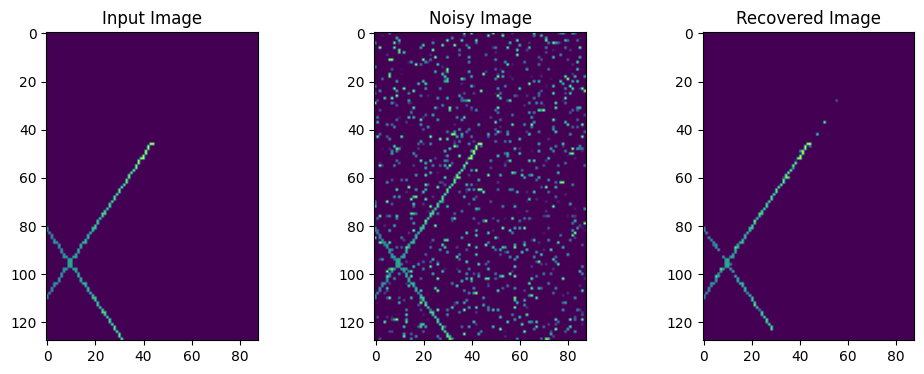

C:\Users\Ada\AppData\Local\Temp\ipykernel_33104\4108860031.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  direct = quantify_performance(torch.tensor(input_image), torch.tensor(recovered_image), "Direct Recovery", time_dimension)
Img Files: 1it [00:00,  1.43it/s]


Running Denoiser: DC3D Direct (DL)
DC3D Direct (DL)
Loaded DC3D_Autoencoder_V1


Img Files: 0it [00:00, ?it/s]

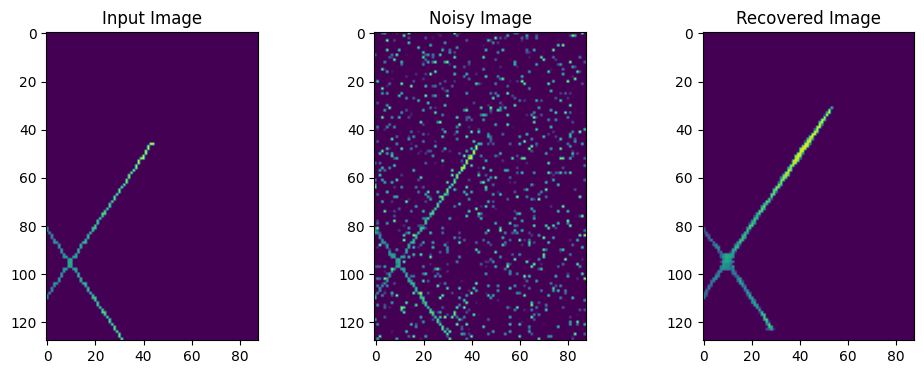

Img Files: 1it [00:00,  1.31it/s]


Running Denoiser: Median Filter (SF)
Median Filter (SF)


Img Files: 0it [00:00, ?it/s]

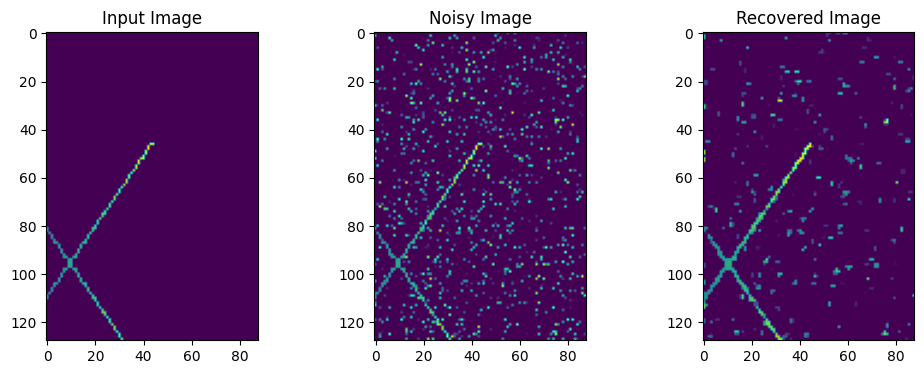

Img Files: 1it [00:00,  2.71it/s]


Running Denoiser: Trilateral Filter (SF)
Trilateral Filter (SF)


Img Files: 0it [00:00, ?it/s]

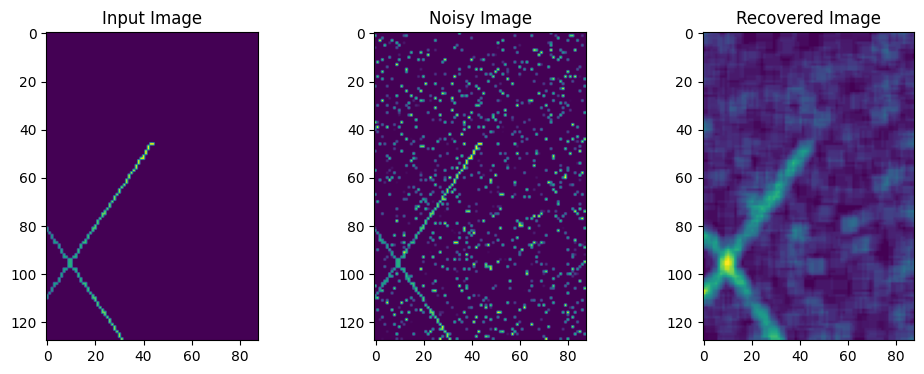

Img Files: 1it [00:00,  1.08it/s]


Running Denoiser: Bilateral Filter (SF)
Bilateral Filter (SF)


Img Files: 0it [00:00, ?it/s]

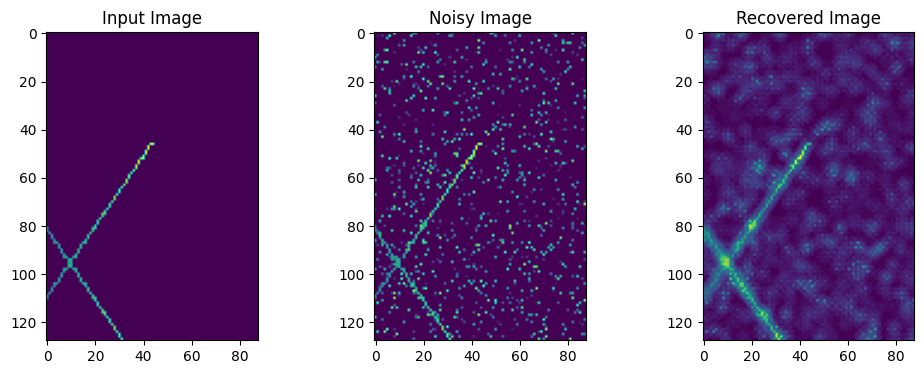

Img Files: 1it [00:00,  2.43it/s]


Running Denoiser: Non-Linear Mean (SF)
Non-Linear Mean (SF)


Img Files: 0it [00:00, ?it/s]

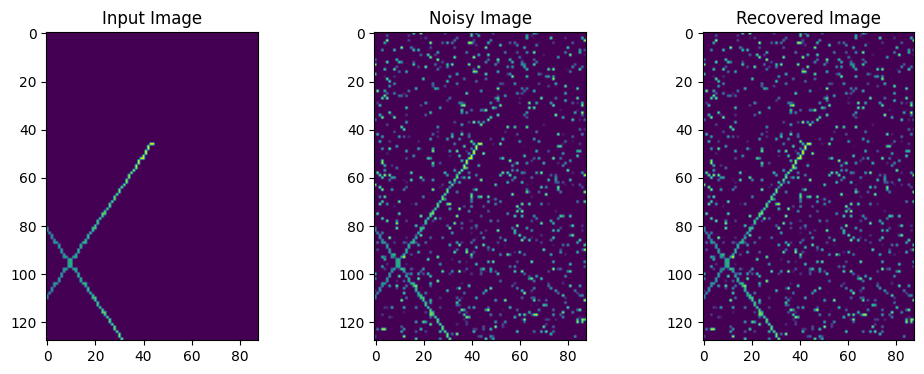

Img Files: 1it [00:00,  2.31it/s]


Running Denoiser: Weighted Nuclear-Norm Minimization (VO)
Weighted Nuclear-Norm Minimization (VO)


Img Files: 0it [00:00, ?it/s]

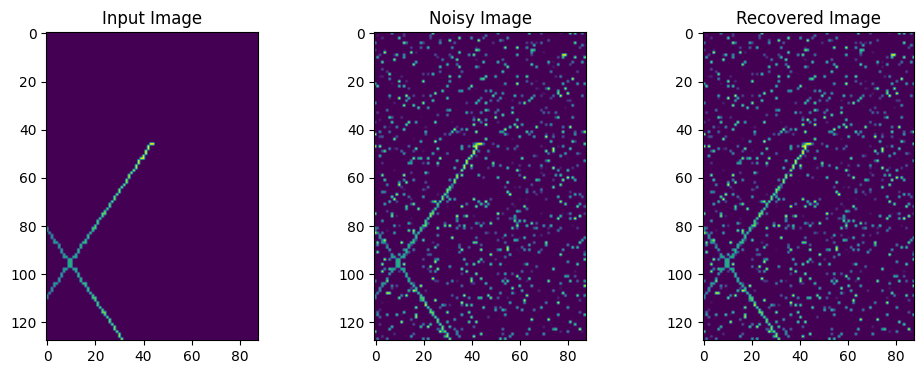

Img Files: 1it [00:00,  2.48it/s]


Running Denoiser: TV Regularisation (VO)
TV Regularisation (VO)


Img Files: 0it [00:00, ?it/s]

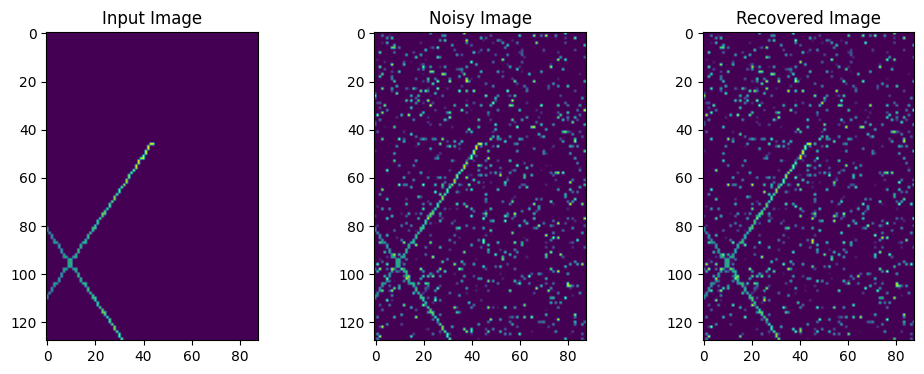

Img Files: 1it [00:00,  2.23it/s]


Running Denoiser: BM3D (DL)
BM3D (DL)


Img Files: 0it [00:00, ?it/s]

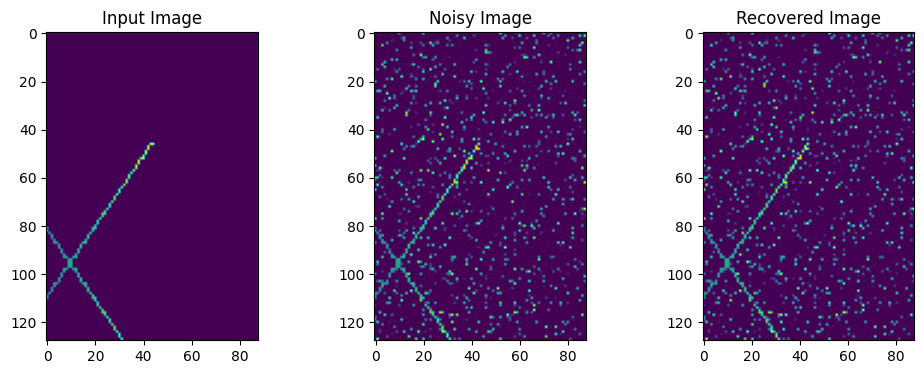

Img Files: 1it [00:01,  1.24s/it]


Running Denoiser: Gaussian Filter (SF)
Gaussian Filter (SF)


Img Files: 0it [00:00, ?it/s]

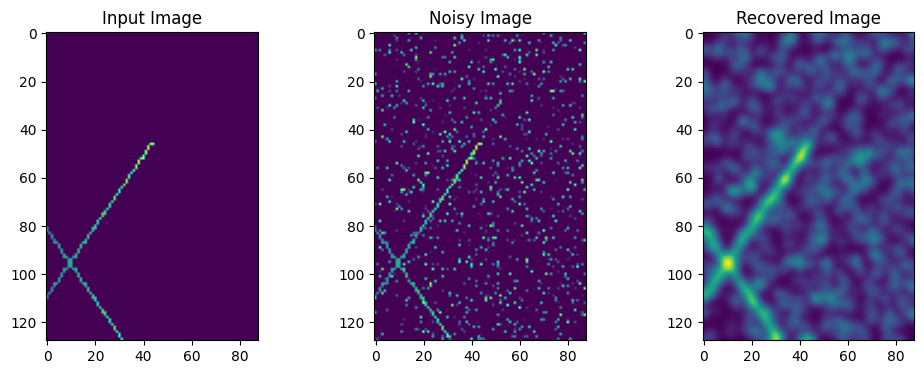

Img Files: 1it [00:00,  1.38it/s]


Completed


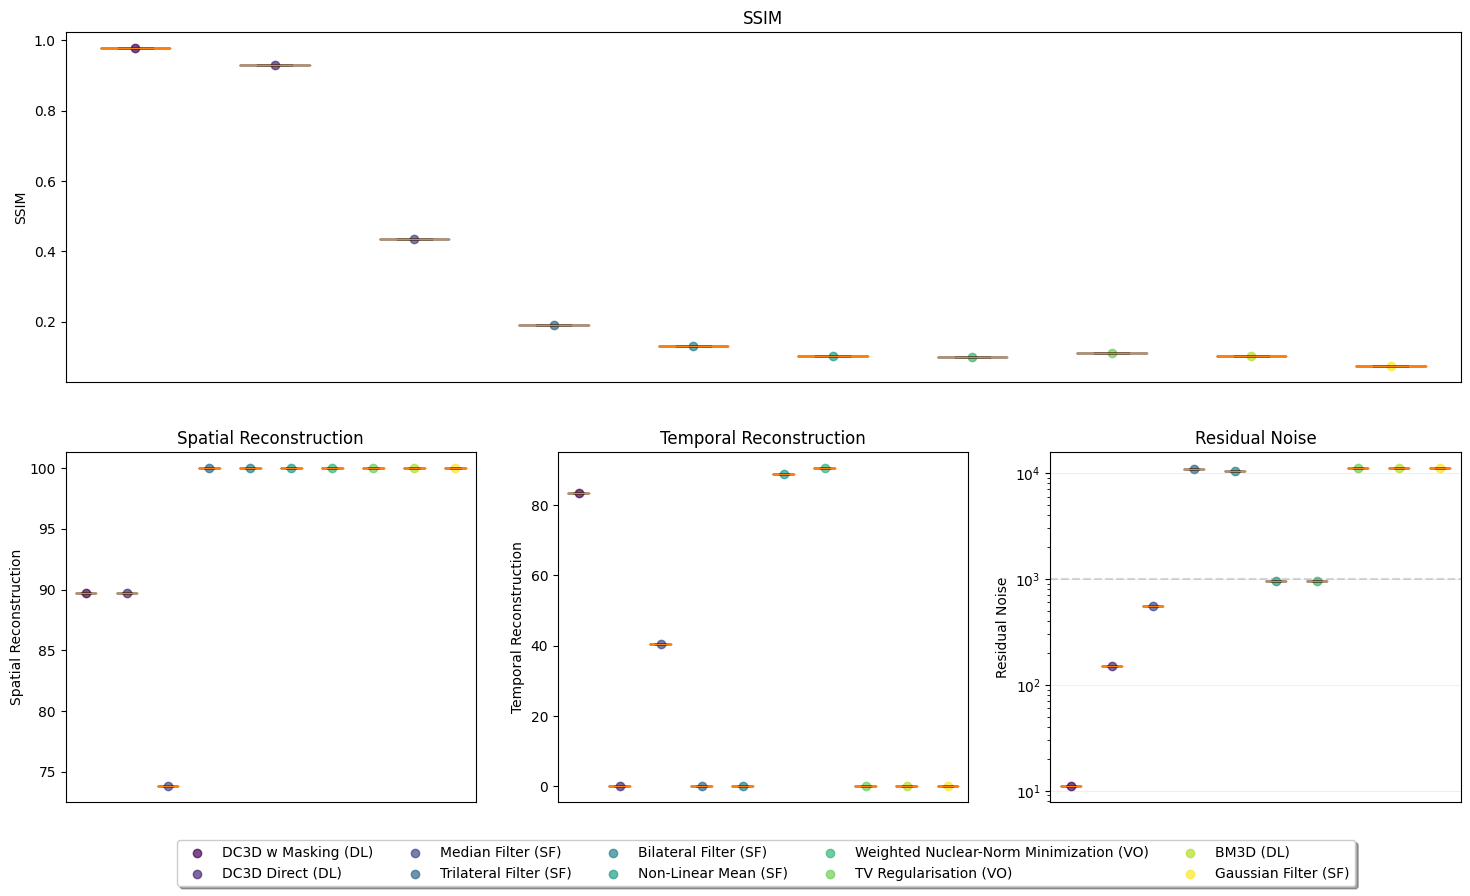

In [632]:
#User Inputs
input_images_path = "N:\Yr 3 Project Datasets\Dataset 24_X10ks\Data"      #Dataset 24_X10ks\Data"
number_of_files = 1
time_dimension = 100
noise_points = 1000
signal_points = 200
plot = 1

#AE Settings
reconstruction_threshold = 0.5
latent_dim = 10
model_name = "D25 50K lr0001 weightedMSE0point99-1 DAE np200" #"D24 50K DAE NP200 AE1PROTECT2"

#Path settings
pretrained_model_path = f"N:\\Yr 3 Project Results\\Archived\\{model_name} - Training Results\\{model_name} - Model + Optimiser State Dicts.pth"
AE_file_folder_path = f"N:\\Yr 3 Project Results\\Archived\\{model_name} - Training Results\\"

#Func Driver
multi_denoiser_results_dict = test_multi_denoisers(denoiser_names, denoiser_functions_list, input_images_path, number_of_files, time_dimension, noise_points, signal_points, reconstruction_threshold, latent_dim, pretrained_model_path, AE_file_folder_path, plot)
print("Completed")

###Plots the results
main_plots(multi_denoiser_results_dict, noise_points)
#all_plots(multi_denoiser_results_dict, noise_points)
#grab_stats_from_multimodel_Results(multi_denoiser_results_dict, method='direct')

Running Denoiser: DC3D w Masking (DL)
DC3D w Masking (DL)
Loaded DC3D_Autoencoder_V1


Img Files: 0it [00:00, ?it/s]

C:\Users\Ada\AppData\Local\Temp\ipykernel_33104\4108860031.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  direct = quantify_performance(torch.tensor(input_image), torch.tensor(recovered_image), "Direct Recovery", time_dimension)
Img Files: 5000it [16:51,  4.94it/s]


Running Denoiser: DC3D Direct (DL)
DC3D Direct (DL)
Loaded DC3D_Autoencoder_V1


Img Files: 5000it [16:03,  5.19it/s]


Running Denoiser: Median Filter (SF)
Median Filter (SF)


Img Files: 5000it [02:10, 38.20it/s]


Running Denoiser: Trilateral Filter (SF)
Trilateral Filter (SF)


Img Files: 5000it [42:17,  1.97it/s]


Running Denoiser: Bilateral Filter (SF)
Bilateral Filter (SF)


Img Files: 5000it [01:35, 52.10it/s]


Running Denoiser: Non-Linear Mean (SF)
Non-Linear Mean (SF)


Img Files: 5000it [04:02, 20.61it/s]


Running Denoiser: Weighted Nuclear-Norm Minimization (VO)
Weighted Nuclear-Norm Minimization (VO)


Img Files: 5000it [01:31, 54.46it/s]


Running Denoiser: TV Regularisation (VO)
TV Regularisation (VO)


Img Files: 5000it [03:05, 26.97it/s]


Running Denoiser: BM3D (DL)
BM3D (DL)


Img Files: 5000it [1:12:29,  1.15it/s]


Running Denoiser: Gaussian Filter (SF)
Gaussian Filter (SF)


Img Files: 5000it [01:32, 54.05it/s]


Completed


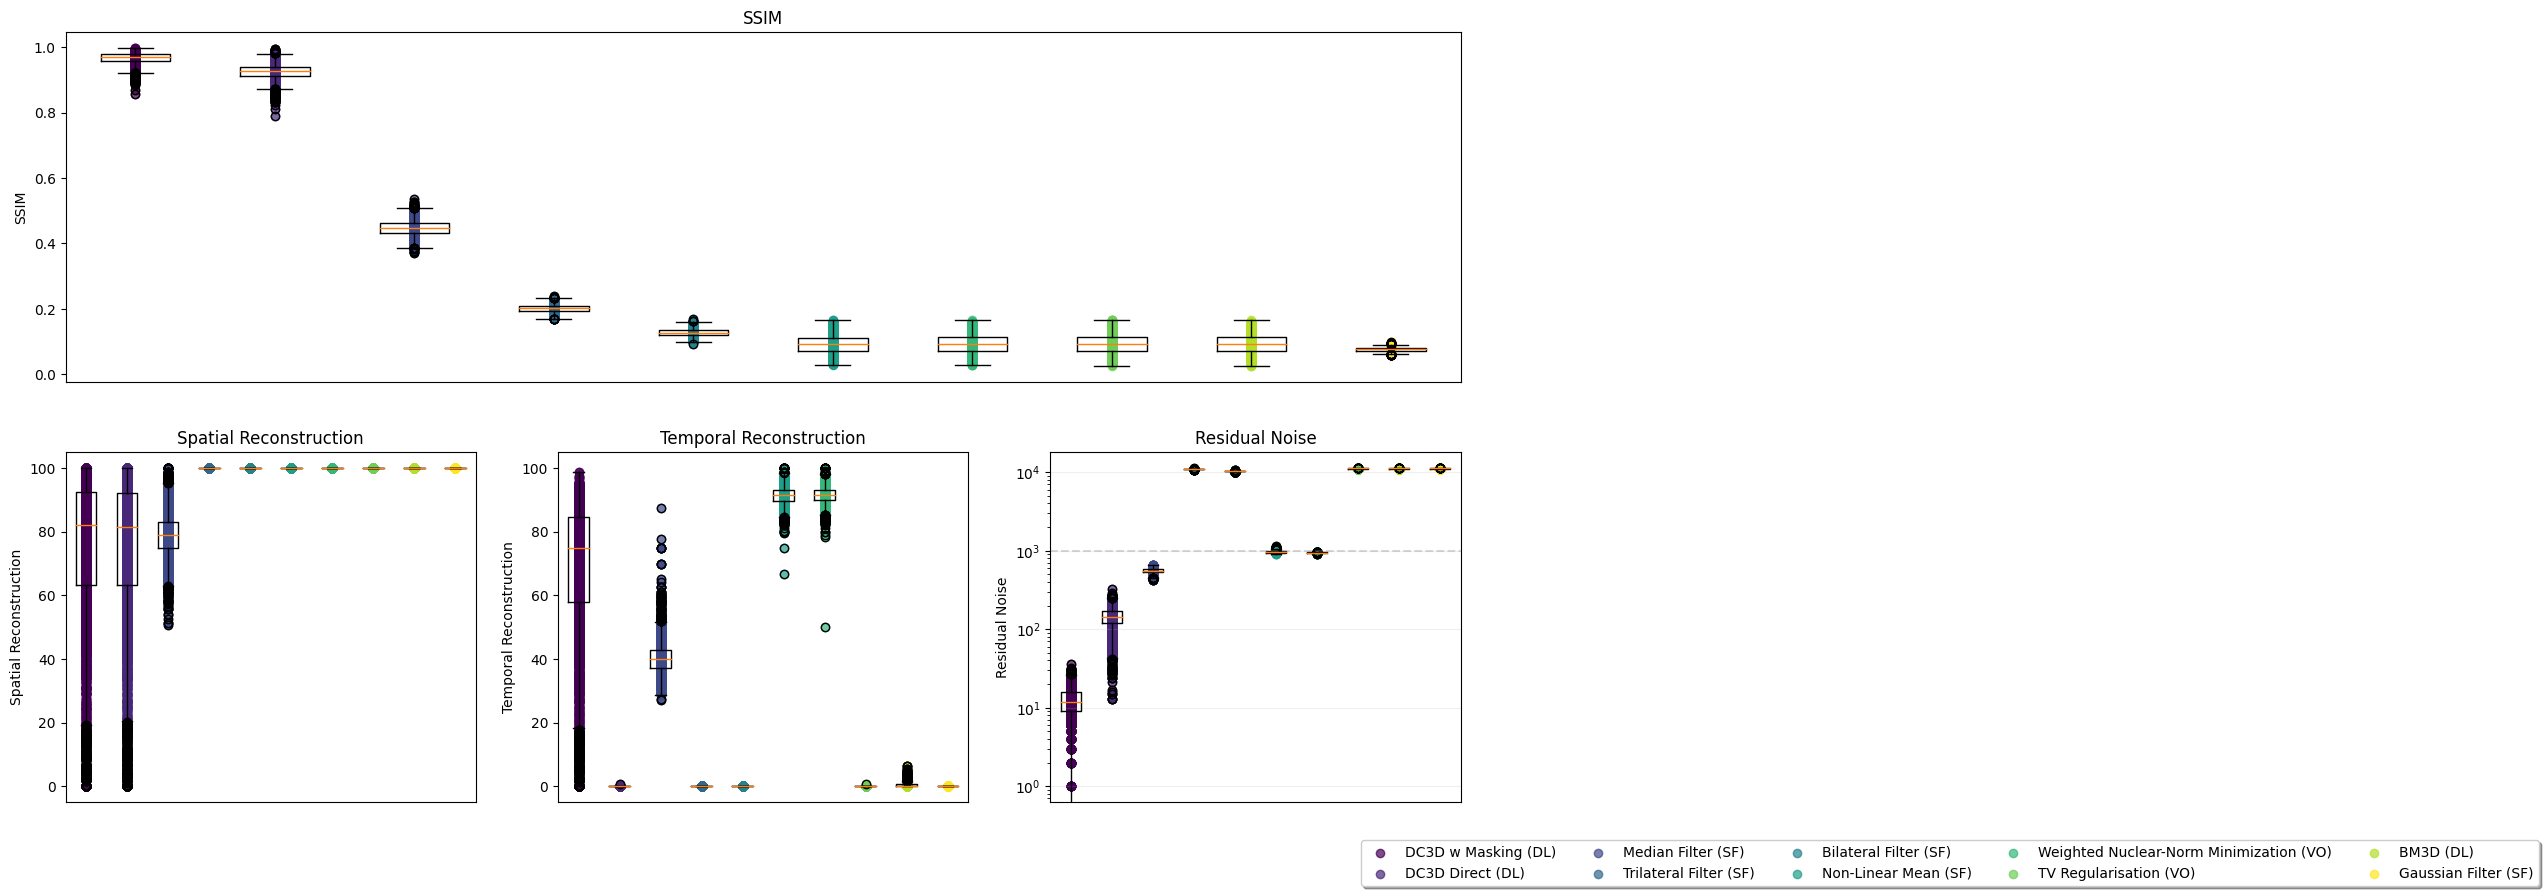

In [633]:
#User Inputs
input_images_path = "N:\Yr 3 Project Datasets\Dataset 24_X10ks\Data"      #Dataset 24_X10ks\Data"
number_of_files = 5000
time_dimension = 100
noise_points = 1000
signal_points = 200
plot = 0

#AE Settings
reconstruction_threshold = 0.5
latent_dim = 10
model_name = "D25 50K lr0001 weightedMSE0point99-1 DAE np200" #"D24 50K DAE NP200 AE1PROTECT2"

#Path settings
pretrained_model_path = f"N:\\Yr 3 Project Results\\Archived\\{model_name} - Training Results\\{model_name} - Model + Optimiser State Dicts.pth"
AE_file_folder_path = f"N:\\Yr 3 Project Results\\Archived\\{model_name} - Training Results\\"

#Func Driver
multi_denoiser_results_dict = test_multi_denoisers(denoiser_names, denoiser_functions_list, input_images_path, number_of_files, time_dimension, noise_points, signal_points, reconstruction_threshold, latent_dim, pretrained_model_path, AE_file_folder_path, plot)
print("Completed")



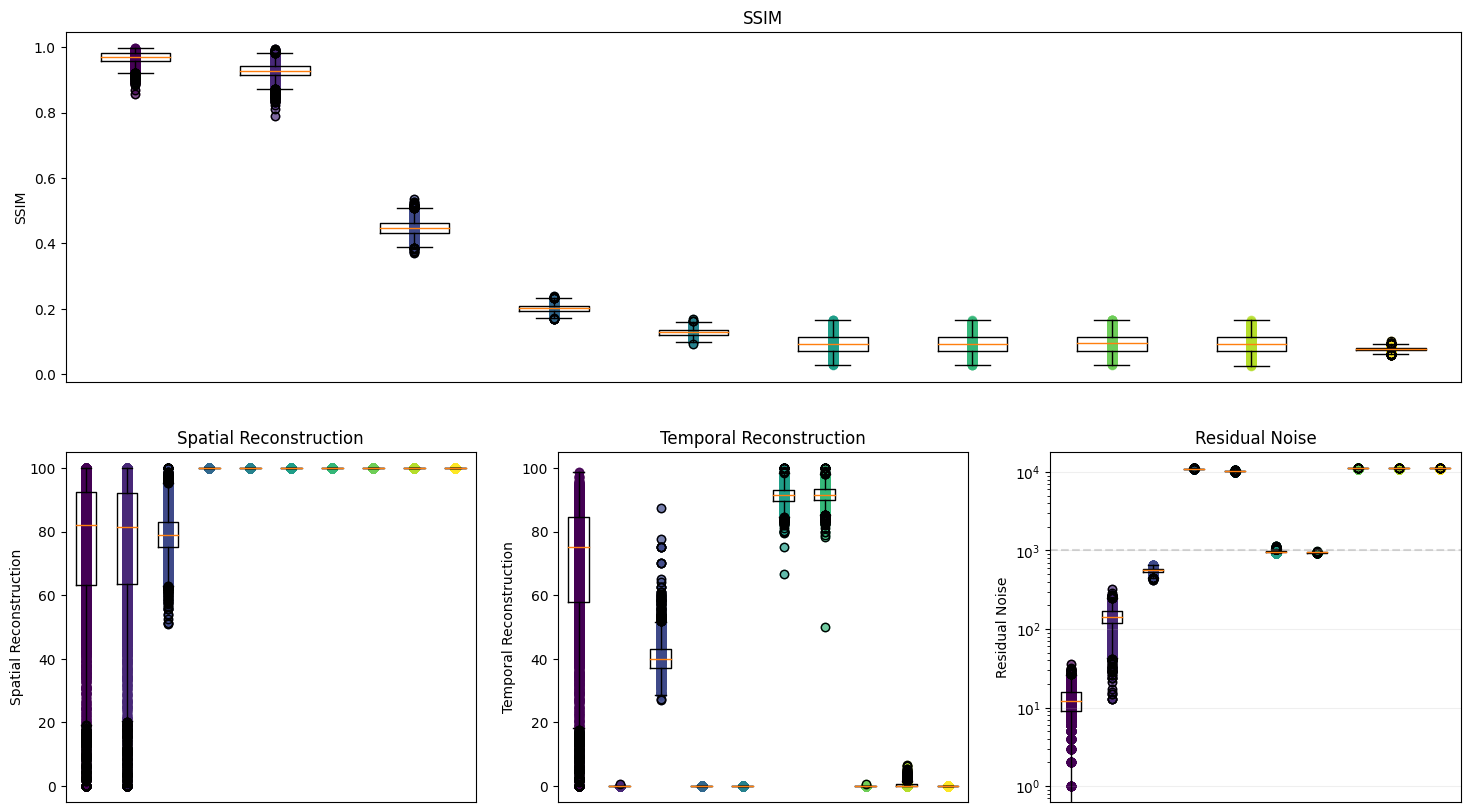

In [646]:
###Plots the results
main_plots(multi_denoiser_results_dict, noise_points)
#all_plots(multi_denoiser_results_dict, noise_points)
#grab_stats_from_multimodel_Results(multi_denoiser_results_dict, method='direct')